# CNN

In [1]:
print("Let's Make a CNN")

Let's Make a CNN


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb
from tqdm import tqdm

class FlexibleCNN(nn.Module):
    def __init__(self, 
                 input_shape=(3, 224, 224),
                 num_classes=10,
                 num_filters=[32, 64, 128, 256, 512],
                 kernel_size=3,
                 dropout=0.5,
                 batch_norm=True,
                 conv_activation='ReLU',
                 pooling='max',
                 pooling_kernel_size=2,
                 pooling_stride=2,
                 output_activation='softmax',
                 dense_neurons=512):
        super(FlexibleCNN, self).__init__()
        
        self.conv_layers = nn.ModuleList()
        in_channels = input_shape[0]
        
        for filters in num_filters:
            self.conv_layers.append(nn.Conv2d(in_channels, filters, kernel_size=kernel_size, padding=1))
            if batch_norm:
                self.conv_layers.append(nn.BatchNorm2d(filters))
            self.conv_layers.append(getattr(nn, conv_activation)())
            if pooling == 'max':
                self.conv_layers.append(nn.MaxPool2d(kernel_size=pooling_kernel_size, stride=pooling_stride))
            in_channels = filters
        
        self.flatten_size = self._get_flatten_size(input_shape)
        self.dense_layer = nn.Linear(self.flatten_size, dense_neurons)
        self.dense_activation = getattr(nn, conv_activation)()
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(dense_neurons, num_classes)
        self.output_activation = nn.Softmax(dim=1) if output_activation == 'softmax' else nn.Identity()

    def _get_flatten_size(self, input_shape):
        x = torch.rand(1, *input_shape)
        with torch.no_grad():
            for layer in self.conv_layers:
                x = layer(x)
        return x.view(1, -1).size(1)

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = torch.flatten(x, start_dim=1)
        x = self.dense_layer(x)
        x = self.dense_activation(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return self.output_activation(x)

    def compute_total_params_and_ops(self, input_shape):
        total_params = 0
        total_ops = 0
        h, w = input_shape[1], input_shape[2]
        in_channels = input_shape[0]

        for layer in self.conv_layers:
            if isinstance(layer, nn.Conv2d):
                k = layer.kernel_size[0]
                out_h, out_w = h // 2, w // 2
                total_ops += out_h * out_w * layer.out_channels * in_channels * k * k
                total_params += (in_channels * k * k + 1) * layer.out_channels
                h, w, in_channels = out_h, out_w, layer.out_channels

        total_params += (self.flatten_size + 1) * self.dense_layer.out_features
        total_ops += self.flatten_size * self.dense_layer.out_features

        total_params += (self.dense_layer.out_features + 1) * self.output_layer.out_features
        total_ops += self.dense_layer.out_features * self.output_layer.out_features

        return total_params, total_ops

    def train_model(self, train_loader, val_loader, device,learning_rate=0.1, epochs=5, ):
        self.to(device)
        criterion = torch.nn.CrossEntropyLoss().to(device)
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        for epoch in tqdm(range(epochs), desc="Training Progress", unit="epoch"):
            self.train()
            running_loss, correct, total = 0.0, 0, 0

            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            # for images, labels in train_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                print(images.shape, labels.shape)
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            train_loss = running_loss / total
            train_acc = correct / total

            val_loss, val_acc = self.validate(val_loader, criterion, device)

            # wandb.log({"train_loss": train_loss, "train_acc": train_acc,
            #            "val_loss": val_loss, "val_acc": val_acc})
            print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    def validate(self, val_loader, criterion, device):
        self.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = self(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        return val_loss / total, correct / total


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
device

device(type='cpu')

In [7]:
import os
import torch
import random
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

def get_dataloaders(data_dir, batch_size=32, val_split=0.2, augment=False, image_size=(224, 224)):
    """
    Loads the iNaturalist dataset, applies transformations, and splits the training set while maintaining class balance.
    Parameters:
        data_dir (str): Path to dataset containing 'train' and 'test' folders.
        batch_size (int): Batch size for DataLoader.
        val_split (float): Fraction of training data to use for validation.
        augment (bool): Whether to apply data augmentation to training data.
        image_size (tuple): Target image size for resizing.
    Returns:
        train_loader, val_loader, test_loader
    """

    # Define basic transformations
    transform_train = [
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip() if augment else transforms.Lambda(lambda x: x),
        transforms.RandomRotation(15) if augment else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]

    transform_test = [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]

    transform_train = transforms.Compose([t for t in transform_train if not isinstance(t, transforms.Lambda)])
    transform_test = transforms.Compose(transform_test)

    # Load datasets
    train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=transform_train)
    test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=transform_test)

    # Stratified split for validation set
    train_indices, val_indices = stratified_split(train_dataset, val_split)
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(train_dataset, val_indices)

    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

def stratified_split(dataset, val_split):
    """
    Splits dataset into training and validation sets with class balance.
    """
    labels = np.array([dataset.targets[i] for i in range(len(dataset))])
    train_indices, val_indices = train_test_split(
        np.arange(len(labels)), test_size=val_split, stratify=labels, random_state=42
    )
    return train_indices, val_indices

# Example usage
# data_dir = "path_to_inat_dataset"
# train_loader, val_loader, test_loader = get_dataloaders(data_dir, augment=True)


In [39]:
nn = FlexibleCNN()

(7999, 2000, 2000)

In [8]:
data_dir = "inaturalist_12k"  # Replace with your dataset path
train_loader, val_loader, test_loader = get_dataloaders(data_dir, augment=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor(8)


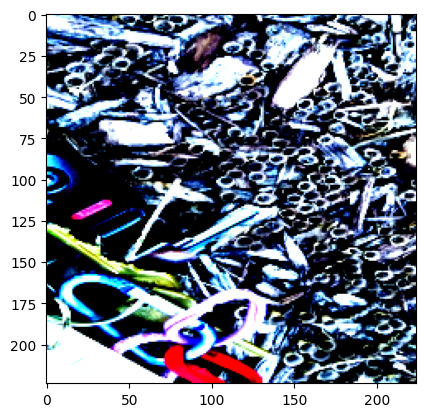

In [23]:
import matplotlib.pyplot as plt
import numpy as np

for i in train_loader:
    a , b = i
    print(a[10].shape)
    plt.imshow(np.transpose(a[0].numpy(), (1, 2, 0)))
    print(b[10])
    # print(i[0][0].shape)
    break

In [ ]:
nn.train_model(train_loader, val_loader, device = device, epochs=1, learning_rate=0.001)

Training Progress:   0%|          | 0/1 [00:00<?, ?epoch/s]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from torchvision import models
from torch.utils.data import DataLoader
from inat_preprocessing import get_dataloaders
from cnn_model import CNN  # Assuming CNN class is in cnn_model.py

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct = 0.0, 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss, correct = 0.0, 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return val_loss / total, correct / total

def train_model(config=None):
    with wandb.init(config=config):
        config = wandb.config
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Data Loaders
        train_loader, val_loader, _ = get_dataloaders(
            data_dir="/path/to/inat_dataset",
            batch_size=config.batch_size,
            augment=config.augment
        )

        # Model
        model = CNN(
            num_filters=config.num_filters,
            kernel_size=config.kernel_size,
            dropout=config.dropout,
            batch_norm=config.batch_norm,
            conv_activation=config.conv_activation
        ).to(device, non_blocking=True)

        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

        for epoch in range(config.epochs):
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc = validate(model, val_loader, criterion, device)
            
            wandb.log({"train_loss": train_loss, "train_acc": train_acc,
                       "val_loss": val_loss, "val_acc": val_acc})
            print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        wandb.finish()



In [ ]:
if __name__ == "__main__":
    sweep_config = {
        "method": "random",
        "metric": {"name": "val_acc", "goal": "maximize"},
        "parameters": {
            "batch_size": {"values": [32, 64]},
            "num_filters": {"values": [[32, 64, 128, 256, 512], [64, 128, 256, 512, 1024]]},
            "kernel_size": {"values": [3, 5]},
            "dropout": {"values": [0.2, 0.3]},
            "batch_norm": {"values": [True, False]},
            "conv_activation": {"values": ["ReLU", "GELU", "SiLU", "Mish"]},
            "augment": {"values": [True, False]},
            "learning_rate": {"values": [0.001, 0.0005]},
            "epochs": {"values": [10, 20]}
        }
    }
    sweep_id = wandb.sweep(sweep_config, project="inat-cnn-sweep")
    wandb.agent(sweep_id, train_model, count=20)